# Data understanding and exploration

In [ ]:
from nltk import FreqDist, SnowballStemmer, WordNetLemmatizer, word_tokenize, FreqDist, pos_tag
import string
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import operator
import nltk
import numpy as np
import logging
import gensim 
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import pickle
from operator import itemgetter
from gensim.test.utils import datapath
import warnings
from collections import Counter
warnings.filterwarnings("ignore")
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [ ]:
# read file
df = pd.read_csv('osha.txt',delimiter='\t',header=None,names=['ID','Title','Text'])
df.head()

,ID,Title,Text
0,201079928,Employee Is Burned By Forklift Radiator Fluid,At approximately 11:30 a.m. on November 13 2...
1,202561825,Employee Falls From Flatbed Trailer And Later...,On August 30 2013 Employee #1 was working f...
2,200361855,Two Workers Are Struck By Motor Vehicle And O...,On August 27 2013 Employees #1 and #2 of T...
3,200361863,Employee Is Struck By Bales Of Wire And Killed,On August 26 2013 Employee #1 with Lee Iro...
4,201079324,Employee Is Splashed With Hot Water And Is Bu...,On July 14 2013 Employee #1 vacuum pump tr...


In [ ]:
# shape of osha data
# records - 10k
# variables - 3
df.shape

(10000, 3)

In [ ]:
# first 10 Text records
for i in df['Text'][:10]:
  print(i)
  print('*'*100)

 At approximately 11:30 a.m. on November 13  2013  Employee #1  with Edco Waste  & Recycling Services  was operating a forklift (Linde Lift Truck; Serial  Number: H2X393S04578; identified by the employer as FL-3) from approximately  4:00 a.m.  moving bales of recyclable paper products from a collection area in  the yard into trucks. Then  Employee #1 cleaned and was replacing an air  filter on the forklift FL-3. To clean out the air filter  Employee #1 parked  FL-3 in the doorway of the maintenance building. The air filter was located on  the rear of the forklift  behind the cab frame on the driver's side. Employee  #1 removed the air filter and cleaned it out  and then he climbed up onto the  back of the forklift to replace it. While up on the back of the forklift   Employee #1's foot dislodged the cooling system radiator cap. The fluid in the  lift truck's cooling system was hot and under pressure from being operated all  morning. The hot fluid sprayed up and out of the reservoir. Em

In [ ]:
# get length of each Text record in dataframe
x=df['Text'].apply(lambda x:len(word_tokenize(x)))

In [ ]:
# Longest Text record
np.max(np.array(x))

804

In [ ]:
# Median length of Text records
np.median(np.array(x))

105.0

In [ ]:
# get length of each Text record in dataframe
x=df['Title'].apply(lambda x:len(word_tokenize(x)))

In [ ]:
# Mininum Title record
np.min(np.array(x))

1

In [ ]:
# Longest Title record
np.max(np.array(x))

13

In [ ]:
# Median length of Title records
np.median(np.array(x))

7.0

In [ ]:
# Retrieve Text records with length 3
df2=df.copy()
df2['text_len']=df2['Text'].apply(lambda x:len(word_tokenize(x)))
df2=df2.loc[df2['text_len']==3]
set(df2['Text'])

{'InspectionOpen DateSICEstablishment Name'}

In [ ]:
# Preprocessing functions

stop = stopwords.words('english')+['would', 'could']
wnl = nltk.WordNetLemmatizer()

def lemmatizer(wpos):
    lemmas = []
    for w, pos in wpos:
        if pos[0] in ('N', 'V', 'J', 'R'):
            if pos in ('NNS', 'RBR', 'RBS', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'):
                lemmas.append(wnl.lemmatize(w.lower(), pos = pos[0].lower()))
            elif pos in ('JJR', 'JJS'):
                lemmas.append(wnl.lemmatize(w.lower(), pos = 'a'))
            else:
                lemmas.append(w.lower())
    return lemmas

def myPrep(tt):
    toks = lemmatizer(pos_tag(word_tokenize(tt)))
    toks = [ t for t in toks if t.isalpha()==True]
    toks = [ t for t in toks if t not in stop ]
    toks = [ t for t in toks if len(t) >= 3 ]
    return toks

{'employee': 7806, 'kill': 1632, 'fall': 1500, 'injure': 1133, 'struck': 1071, 'worker': 809, 'finger': 746, 'burn': 636, 'falls': 558, 'die': 555, 'shock': 511, 'fractures': 505, 'electric': 474, 'caught': 448, 'killed': 439, 'injured': 434, 'machine': 405, 'dies': 402, 'suffers': 396, 'truck': 380, 'explosion': 327, 'crush': 319, 'amputates': 299, 'hand': 297, 'later': 281, 'burns': 281, 'amputate': 277, 'leg': 272, 'ladder': 259, 'fire': 254, 'arm': 239, 'fracture': 222, 'amputated': 210, 'crane': 204, 'sustains': 202, 'press': 179, 'crushed': 176, 'chemical': 172, 'head': 165, 'expose': 162, 'roof': 161, 'hot': 143, 'run': 143, 'foot': 142, 'pin': 141, 'injures': 140, 'saw': 137, 'forklift': 136, 'gas': 135, 'flash': 135, 'tree': 134, 'lift': 131, 'line': 130, 'tank': 127, 'collapse': 122, 'electrocuted': 122, 'power': 119, 'back': 113, 'conveyor': 113, 'scaffold': 112, 'work': 111, 'vehicle': 108, 'exposure': 101, 'accident': 101, 'thumb': 100, 'water': 98, 'pipe': 98, 'attack': 9

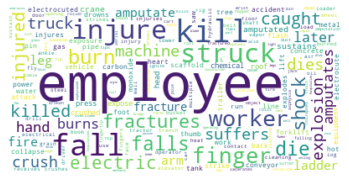

In [ ]:
# Preprocess Title records
df['Title_clean']=df['Title'].apply(myPrep)
grain_clean = list(df['Title_clean'])
grain_flat = [ c for l in grain_clean for c in l ]
fd_grain = FreqDist(grain_flat)
print(dict( sorted(fd_grain.items(), key=operator.itemgetter(1),reverse=True)))

wc_grain = WordCloud(background_color="white").generate_from_frequencies(fd_grain)
plt.imshow(wc_grain, interpolation='bilinear')
plt.axis("off")
plt.show()

{'employee': 37763, 'approximately': 6070, 'work': 5570, 'use': 3515, 'coworker': 3354, 'hospitalize': 3287, 'truck': 3132, 'hospital': 3062, 'hand': 2846, 'fell': 2791, 'right': 2660, 'machine': 2624, 'foot': 2492, 'line': 2371, 'injury': 2294, 'left': 2263, 'transport': 2159, 'back': 2142, 'area': 2112, 'burn': 2004, 'medical': 1982, 'cause': 1971, 'remove': 1945, 'ground': 1911, 'side': 1875, 'day': 1873, 'finger': 1798, 'strike': 1764, 'floor': 1747, 'die': 1646, 'employer': 1645, 'move': 1585, 'take': 1575, 'accident': 1563, 'head': 1546, 'number': 1540, 'sustain': 1516, 'operator': 1509, 'center': 1505, 'place': 1502, 'operate': 1501, 'fire': 1495, 'lift': 1489, 'fall': 1446, 'top': 1426, 'kill': 1413, 'cut': 1410, 'fracture': 1405, 'tank': 1380, 'treat': 1375, 'power': 1370, 'water': 1358, 'ladder': 1318, 'time': 1317, 'concrete': 1311, 'worker': 1287, 'company': 1285, 'emergency': 1264, 'metal': 1259, 'crane': 1259, 'release': 1258, 'pull': 1232, 'arm': 1179, 'building': 1174, 

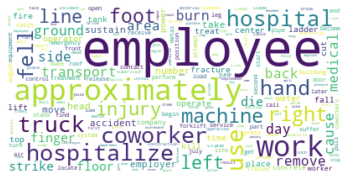

In [ ]:
# Preprocess Text records
df['Text_clean']=df['Text'].apply(myPrep)
grain_clean = list(df['Text_clean'])
grain_flat = [ c for l in grain_clean for c in l ]
fd_grain = FreqDist(grain_flat)
print(dict( sorted(fd_grain.items(), key=operator.itemgetter(1),reverse=True)))

wc_grain = WordCloud(background_color="white").generate_from_frequencies(fd_grain)
plt.imshow(wc_grain, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
df.head()

,ID,Title,Text,Title_clean,Text_clean
0,201079928,Employee Is Burned By Forklift Radiator Fluid,At approximately 11:30 a.m. on November 13 2...,"[employee, burn, forklift, radiator, fluid]","[approximately, november, employee, edco, wast..."
1,202561825,Employee Falls From Flatbed Trailer And Later...,On August 30 2013 Employee #1 was working f...,"[employee, falls, flatbed, trailer, later, dies]","[august, employee, work, flatbed, trailer, wor..."
2,200361855,Two Workers Are Struck By Motor Vehicle And O...,On August 27 2013 Employees #1 and #2 of T...,"[worker, strike, motor, vehicle, kill]","[august, employees, templar, construction, com..."
3,200361863,Employee Is Struck By Bales Of Wire And Killed,On August 26 2013 Employee #1 with Lee Iro...,"[employee, struck, bales, wire, killed]","[august, employee, lee, iron, metal, company, ..."
4,201079324,Employee Is Splashed With Hot Water And Is Bu...,On July 14 2013 Employee #1 vacuum pump tr...,"[employee, splash, hot, water, burned]","[july, employee, vacuum, pump, truck, driver, ..."


# Q1. What are the major types of accidents reflected in the reports?

`Answer:`

`Topic 0 - Road/Vehicle Accident`

`Topic 1 - Injury via Machine/Weapon`

`Topic 2 - Falling`

`Topic 3 - Electrocution`

`Topic 4 - Fire/Burn`

In [ ]:
# preprocessing function
stop = ['employee', 'approximately', 'work', 'use', 'coworker', 'hospitalize']

def myPrep2(toks):
    toks = [ t for t in toks if t not in stop ]
    return toks

In [ ]:
toks = df['Text_clean'].apply(myPrep2)
toks

0       [november, edco, waste, recycling, services, o...
1       [august, flatbed, trailer, fell, flatbed, trai...
2       [august, employees, templar, construction, com...
3       [august, lee, iron, metal, company, forklift, ...
4       [july, vacuum, pump, truck, driver, operator, ...
                              ...                        
9995    [june, remotely, control, locomotive, pugh, ra...
9996    [april, operate, steam, locomotive, disneyland...
9997    [operate, remote, control, rail, engine, move,...
9998    [september, rid, fireman, engineer, cab, steam...
9999    [march, contract, worker, refinery, complete, ...
Name: Text_clean, Length: 10000, dtype: object

In [ ]:
# Use dictionary (built from corpus) to prepare a Document Term Matrix DTM (using frequency)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
dictionary = corpora.Dictionary(toks)
print(dictionary)

# Filter off any words with document frequency less than 2, or appearing in more than 90% documents
dictionary.filter_extremes(no_below=2, no_above=0.9)
print(dictionary)

2022-01-07 11:17:51,994 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2022-01-07 11:17:52,543 : INFO : built Dictionary(16200 unique tokens: ['air', 'area', 'assistance', 'back', 'bale']...) from 10000 documents (total 509427 corpus positions)
2022-01-07 11:17:52,568 : INFO : discarding 7065 tokens: [('templar', 1), ('cubes', 1), ('taqueria', 1), ('placers', 1), ('corrective', 1), ('wadkin', 1), ('monique', 1), ('placerville', 1), ('bostitch', 1), ('duyck', 1)]...
2022-01-07 11:17:52,570 : INFO : keeping 9135 tokens which were in no less than 2 and no more than 9000 (=90.0%) documents
2022-01-07 11:17:52,582 : INFO : resulting dictionary: Dictionary(9135 unique tokens: ['air', 'area', 'assistance', 'back', 'bale']...)


Dictionary(16200 unique tokens: ['air', 'area', 'assistance', 'back', 'bale']...)
Dictionary(9135 unique tokens: ['air', 'area', 'assistance', 'back', 'bale']...)


In [ ]:
# dtm here is a list of lists, which is exactly a matrix
dtm = [dictionary.doc2bow(d) for d in toks]

In [ ]:
lda = gensim.models.ldamodel.LdaModel(dtm, num_topics = 5, id2word = dictionary, passes=20,chunksize=1000,random_state=10)

2022-01-07 11:17:53,009 : INFO : using symmetric alpha at 0.2
2022-01-07 11:17:53,011 : INFO : using symmetric eta at 0.2
2022-01-07 11:17:53,017 : INFO : using serial LDA version on this node
2022-01-07 11:17:53,028 : INFO : running online (multi-pass) LDA training, 5 topics, 20 passes over the supplied corpus of 10000 documents, updating model once every 1000 documents, evaluating perplexity every 10000 documents, iterating 50x with a convergence threshold of 0.001000
2022-01-07 11:17:53,030 : INFO : PROGRESS: pass 0, at document #1000/10000
2022-01-07 11:17:53,788 : INFO : merging changes from 1000 documents into a model of 10000 documents
2022-01-07 11:17:53,799 : INFO : topic #0 (0.200): 0.007*"air" + 0.006*"ground" + 0.006*"hospital" + 0.006*"injury" + 0.006*"cause" + 0.005*"fell" + 0.005*"machine" + 0.005*"truck" + 0.005*"foot" + 0.005*"area"
2022-01-07 11:17:53,801 : INFO : topic #1 (0.200): 0.010*"machine" + 0.008*"truck" + 0.007*"air" + 0.006*"right" + 0.005*"area" + 0.005*"l

In [ ]:
lda.show_topics(10)

[(0,
  '0.031*"truck" + 0.011*"back" + 0.010*"forklift" + 0.009*"trailer" + 0.009*"tree" + 0.008*"driver" + 0.008*"hospital" + 0.008*"strike" + 0.007*"transport" + 0.007*"load"'),
 (1,
  '0.024*"machine" + 0.022*"hand" + 0.017*"finger" + 0.016*"right" + 0.014*"left" + 0.011*"number" + 0.010*"press" + 0.009*"operate" + 0.008*"catch" + 0.006*"amputate"'),
 (2,
  '0.020*"fell" + 0.013*"foot" + 0.012*"ladder" + 0.011*"fall" + 0.010*"floor" + 0.010*"crane" + 0.010*"lift" + 0.009*"ground" + 0.009*"concrete" + 0.008*"roof"'),
 (3,
  '0.037*"line" + 0.024*"power" + 0.015*"electrical" + 0.013*"pole" + 0.013*"contact" + 0.012*"electric" + 0.009*"ground" + 0.008*"electrocute" + 0.008*"conductor" + 0.007*"cable"'),
 (4,
  '0.014*"burn" + 0.011*"tank" + 0.011*"fire" + 0.009*"hospital" + 0.008*"water" + 0.007*"day" + 0.006*"gas" + 0.006*"area" + 0.006*"room" + 0.005*"degree"')]

In [ ]:
# Get the topic distribution of documents
doc_topics = lda.get_document_topics(dtm)

In [ ]:
# show the topic distributions
for j in range(5):
  print('Topic:',j)
  print('*'*10)
  c=0
  for i in range(0, df.shape[0]):
    x = max(doc_topics[i], key=itemgetter(1))[0]
    if(x==j):
      print("Document",i,"-",df.iloc[i,1])
      c=c+1
    if(c==10):
      break
  print('-'*50) 

Topic: 0
**********
Document 1 -  Employee Falls From Flatbed Trailer And Later Dies 
Document 2 -  Two Workers Are Struck By Motor Vehicle And One Is Killed 
Document 8 -  Employee Fractures Abdomen When Run Over By Tug Cart 
Document 11 -  Employee Abdomen And Head Injury In Slip And Fall On Tarp 
Document 12 -  Employee Sustains Ruptured Spleen After Board Kicks Back 
Document 14 -  Logger Is Injured When Butt Of Tree Kicks Out  Strikes Him 
Document 17 -  Bulldozer Operator Is Crushed While Working On Engine 
Document 26 -  Driver Hurt When Truck Unloading Sand Overturns 
Document 27 -  Employee Sprains Knee When Struck By Forklift 
Document 29 -  Employee Is Killed In Avalance 
--------------------------------------------------
Topic: 1
**********
Document 6 -  Employee Injures Self With Knife 
Document 10 -  Carpenter Injured In Abdomen When Saw Kicks Back 
Document 13 -  Employee'S Body Is Caught In Asphalt Machine  Dies 
Document 19 -  Employee'S Abdomen Is Penetrated By A Wood

# Q2. Which type of accidents has more occurrences?

`Answer:` 

`Descending Order = Falling ->`

`Fire/Burn -> Road/Vehicle Accident ->`



`Injury via Machine/Weapon -> Electrocution`

In [ ]:
# Select the best topic (with highest score) for each document
x = [max(t, key=itemgetter(1))[0] for t in doc_topics]
d=dict(Counter(x))
sorted_d = dict(sorted(d.items(), key=operator.itemgetter(1),reverse=True))
print(sorted_d)

{2: 2539, 4: 2338, 0: 2001, 1: 1982, 3: 1140}


# Q3. Which part of the human body is injured most? 

`Answer:` 

`Top 5 in Descending Order = Hand -> Foot -> Head -> Finger -> Arm`

In [ ]:
def preprocess(sent):
  l = pos_tag(word_tokenize(sent), tagset='universal')
  l = [i[0] for i in l if i[1]=='NOUN']
  sent = " ".join(l)

  return list(set(myPrep(sent)))

In [ ]:
x = list(df['Text'].apply(preprocess))

In [ ]:
x = [item for sublist in x for item in sublist]

In [ ]:
d=dict(Counter(x))
sorted_d = dict(sorted(d.items(), key=operator.itemgetter(1),reverse=True))
print(sorted_d)

{'hospital': 2639, 'injury': 1957, 'hand': 1701, 'foot': 1610, 'area': 1565, 'day': 1559, 'ground': 1322, 'side': 1280, 'center': 1261, 'line': 1216, 'truck': 1198, 'accident': 1161, 'burn': 1140, 'time': 1114, 'head': 1108, 'floor': 1108, 'emergency': 1087, 'machine': 1079, 'employer': 1064, 'company': 1036, 'finger': 1024, 'treatment': 981, 'operator': 978, 'fracture': 968, 'number': 954, 'worker': 892, 'july': 876, 'august': 846, 'fire': 845, 'arm': 820, 'top': 810, 'service': 804, 'june': 802, 'power': 797, 'september': 797, 'water': 796, 'part': 787, 'equipment': 777, 'medical': 771, 'october': 748, 'site': 737, 'metal': 735, 'end': 727, 'november': 713, 'system': 683, 'air': 669, 'coworkers': 666, 'march': 662, 'may': 656, 'construction': 636, 'model': 633, 'body': 620, 'operation': 615, 'april': 611, 'face': 598, 'leg': 593, 'control': 586, 'back': 579, 'department': 571, 'piece': 567, 'incident': 566, 'employees': 559, 'ladder': 557, 'building': 555, 'supervisor': 550, 'decembe

In [ ]:
ss = wn.synsets('body_part')[0]
hyps = list(set(
                [w for s in ss.closure(lambda s:s.hyponyms()) for w in s.lemma_names()]))
hyps=[w.lower() for w in hyps if '_' not in w]
print(sorted(hyps))
print(len(hyps))

['ab', 'abdomen', 'abdominal', 'abducens', 'abducent', 'abductor', 'abomasum', 'acanthion', 'acetabulum', 'acinus', 'acromion', 'acrosome', 'aculea', 'aculeus', 'acumen', 'adductor', 'adenohypophysis', 'adenoid', 'adhesion', 'adnexa', 'adrenal', 'adventitia', 'afferent', 'afterbirth', 'agnail', 'agonist', 'airway', 'ala', 'albuginea', 'allantois', 'allograft', 'alpha-adrenoceptor', 'alveolus', 'ambulacrum', 'amnion', 'amnios', 'ampulla', 'amygdala', 'ankle', 'anklebone', 'anlage', 'annexa', 'annualry', 'ans', 'antagonist', 'antenna', 'anterior', 'antler', 'antrum', 'anus', 'anvil', 'aorta', 'apodeme', 'aponeurosis', 'apophysis', 'apparatus', 'appendage', 'appendix', 'arachnoid', 'arch', 'archenteron', 'archipallium', 'arcus', 'area', 'areola', 'arista', 'arm', 'armpit', 'arse', 'arsehole', 'arteria', 'arteriola', 'arteriole', 'artery', 'arthromere', 'articulatio', 'articulation', 'articulator', 'arytaenoid', 'arytenoid', 'ass', 'asshole', 'aster', 'asterion', 'astragal', 'astragalus', 

In [ ]:
d={}
for i in hyps:
  try:
    d[i] = sorted_d[i]
  except:
    pass
sorted_d = dict( sorted(d.items(), key=operator.itemgetter(1),reverse=True))
print(sorted_d)
len(sorted_d)

{'hand': 1701, 'foot': 1610, 'area': 1565, 'side': 1280, 'center': 1261, 'head': 1108, 'finger': 1024, 'arm': 820, 'system': 683, 'body': 620, 'face': 598, 'leg': 593, 'back': 579, 'bottom': 371, 'contractor': 364, 'process': 361, 'right': 337, 'hole': 328, 'frame': 308, 'index': 300, 'valve': 289, 'neck': 283, 'chest': 283, 'shoulder': 274, 'pump': 272, 'blade': 272, 'tool': 262, 'rear': 242, 'eye': 241, 'structure': 212, 'plate': 211, 'ankle': 187, 'knee': 181, 'shaft': 175, 'pin': 171, 'thumb': 165, 'wrist': 165, 'middle': 157, 'bone': 156, 'forearm': 155, 'member': 155, 'bridge': 146, 'dock': 140, 'button': 137, 'hip': 136, 'heart': 124, 'corporation': 123, 'seat': 123, 'tube': 118, 'elbow': 112, 'lung': 110, 'rib': 106, 'pelvis': 103, 'pit': 101, 'bag': 99, 'hammer': 98, 'joint': 94, 'grinder': 92, 'vessel': 91, 'opening': 89, 'skin': 88, 'lid': 84, 'ball': 82, 'column': 80, 'toe': 79, 'knuckle': 78, 'torso': 77, 'stick': 75, 'abdomen': 71, 'pad': 70, 'skull': 66, 'hood': 66, 'nai

344

# Q4. What are the more risky occupations involved in such accidents?

`Answer:` 

`Top 5 in Descending Order = Engineering -> Roofing -> Masonry -> Carpentry -> Plumbing`

In [ ]:
def preprocess(sent):
  l = pos_tag(word_tokenize(sent), tagset='universal')
  l = [i[0] for i in l if i[1]=='NOUN']
  sent = " ".join(l)

  return list(set(myPrep(sent)))

In [ ]:
x = list(df['Text'].apply(preprocess))

In [ ]:
x = [item for sublist in x for item in sublist]

In [ ]:
d=dict(Counter(x))
sorted_d2 = dict( sorted(d.items(), key=operator.itemgetter(1),reverse=True))
print(sorted_d2)

{'hospital': 2639, 'injury': 1957, 'hand': 1701, 'foot': 1610, 'area': 1565, 'day': 1559, 'ground': 1322, 'side': 1280, 'center': 1261, 'line': 1216, 'truck': 1198, 'accident': 1161, 'burn': 1140, 'time': 1114, 'head': 1108, 'floor': 1108, 'emergency': 1087, 'machine': 1079, 'employer': 1064, 'company': 1036, 'finger': 1024, 'treatment': 981, 'operator': 978, 'fracture': 968, 'number': 954, 'worker': 892, 'july': 876, 'august': 846, 'fire': 845, 'arm': 820, 'top': 810, 'service': 804, 'june': 802, 'power': 797, 'september': 797, 'water': 796, 'part': 787, 'equipment': 777, 'medical': 771, 'october': 748, 'site': 737, 'metal': 735, 'end': 727, 'november': 713, 'system': 683, 'air': 669, 'coworkers': 666, 'march': 662, 'may': 656, 'construction': 636, 'model': 633, 'body': 620, 'operation': 615, 'april': 611, 'face': 598, 'leg': 593, 'control': 586, 'back': 579, 'department': 571, 'piece': 567, 'incident': 566, 'employees': 559, 'ladder': 557, 'building': 555, 'supervisor': 550, 'decembe

In [ ]:
ss = wn.synsets('occupation')[0]
hyps = list(set(
                [w for s in ss.closure(lambda s:s.hyponyms()) for w in s.lemma_names()]))
#hyps = [" ".join(w.split('_')).lower() for w in hyps]
hyps=[w.lower() for w in hyps if '_' not in w]
print(sorted(hyps))
print(len(hyps))

['academicianship', 'accountancy', 'accountantship', 'accounting', 'admiralty', 'ambassadorship', 'apostleship', 'appointment', 'apprenticeship', 'architecture', 'associateship', 'attorneyship', 'automation', 'bailiffship', 'baronetage', 'basketry', 'berth', 'billet', 'bishopry', 'biz', 'bookbinding', 'booking', 'bookkeeping', 'brainwashing', 'bricklaying', 'cabinetmaking', 'cabinetry', 'cabinetwork', 'cabotage', 'cadetship', 'caliphate', 'calling', 'captaincy', 'captainship', 'cardinalship', 'career', 'carpentry', 'catechesis', 'catering', 'chair', 'chairmanship', 'chancellorship', 'chaplaincy', 'chaplainship', 'chieftaincy', 'chieftainship', 'clerking', 'clerkship', 'coaching', 'cobbling', 'commandership', 'commandery', 'comptrollership', 'computerization', 'confectionery', 'consulship', 'controllership', 'costing', 'councillorship', 'councilorship', 'counsellorship', 'counselorship', 'couture', 'craft', 'crocheting', 'curacy', 'curatorship', 'custodianship', 'cybernation', 'deanery'

In [ ]:
d={}
for i in hyps:
  try:
    d[i] = sorted_d2[i]
  except:
    pass
sorted_d2 = dict( sorted(d.items(), key=operator.itemgetter(1),reverse=True))
print(sorted_d2)
len(sorted_d2)

{'service': 804, 'position': 533, 'place': 401, 'office': 307, 'services': 239, 'land': 110, 'post': 81, 'engineering': 66, 'instruction': 57, 'chair': 53, 'situation': 37, 'walk': 35, 'spot': 35, 'employment': 33, 'roofing': 25, 'president': 23, 'masonry': 23, 'trade': 22, 'carpentry': 21, 'plumbing': 19, 'specialty': 18, 'medium': 15, 'technology': 13, 'medicine': 11, 'painting': 11, 'lighting': 9, 'craft': 8, 'law': 8, 'game': 8, 'sport': 8, 'education': 6, 'berth': 6, 'billet': 6, 'appointment': 6, 'engagement': 5, 'catering': 4, 'farming': 4, 'woodwork': 3, 'spinning': 3, 'regency': 3, 'literature': 2, 'woodworking': 2, 'career': 2, 'treadmill': 1, 'pyrotechnics': 1, 'photography': 1, 'navigation': 1, 'confectionery': 1, 'upholstery': 1, 'bricklaying': 1, 'pottery': 1, 'plum': 1, 'automation': 1, 'workload': 1, 'weaving': 1, 'piecework': 1, 'teaching': 1}


57

In [ ]:
[i for i in list(sorted_d2.keys()) if 'ing' in i or 'y'==i[-1]]

['engineering',
 'roofing',
 'masonry',
 'carpentry',
 'plumbing',
 'specialty',
 'technology',
 'painting',
 'lighting',
 'catering',
 'farming',
 'spinning',
 'regency',
 'woodworking',
 'photography',
 'confectionery',
 'upholstery',
 'bricklaying',
 'pottery',
 'weaving',
 'teaching']